In [1]:
# !pip install tensorflow
# !pip install imbalanced-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df_train_original = pd.read_csv('data/application_train.csv')
df_test_original = pd.read_csv('data/application_test.csv')

### Perform a preprocessing step on the train data

In [4]:
# Drop columns with all NaN values
df_train_original = df_train_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_train_original) * 0.95
df_train_original = df_train_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_train_original = df_train_original.dropna()

# One-hot encode categorical variables
df_train_original = pd.get_dummies(df_train_original)

### Perform a preprocessing step on the test data

In [5]:
# Drop columns with all NaN values
df_test_original = df_test_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_test_original) * 0.95
df_test_original = df_test_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_test_original = df_test_original.dropna()

# One-hot encode categorical variables
df_test_original = pd.get_dummies(df_test_original)

### Remove columns from `df_train_original` that do not exist in `df_test_original`

In [6]:
intersection = list(set(df_train_original.columns) &
                  set(df_test_original.columns))
intersection.append("TARGET")

df_train_original = df_train_original[intersection]

In [7]:
# Separate features and target variable from df_train
X = df_train_original.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train_original['TARGET']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)

# Ensure df_test has the same columns as X_train
df_test_aligned = df_test_original[X_train.columns]

# Transform the test data
X_test_scaled = scaler.transform(df_test_aligned)

In [8]:
# Define the SMOTE sampler
smote = SMOTE(sampling_strategy=0.5, k_neighbors=10,
              random_state=42, n_jobs=-1)
# Fit the sampler to balance the training data
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_scaled, y_train)

c:\Work\Home Credit Default Risk\.venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [9]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train_balanced.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Work\Home Credit Default Risk\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the model with class weights
# class_weights = {0: 1., 1: 10.}  # Adjust the weights as needed


# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping

early_stopping = EarlyStopping(
monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
history = model.fit(X_train_balanced, y_train_balanced, validation_data=(
    X_val_scaled, y_val), epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 0.6542 - loss: 0.6470 - val_accuracy: 0.7449 - val_loss: 0.4604
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - accuracy: 0.6993 - loss: 0.5654 - val_accuracy: 0.7948 - val_loss: 0.4115
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - accuracy: 0.7522 - loss: 0.5142 - val_accuracy: 0.8582 - val_loss: 0.3759
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0.7803 - loss: 0.4763 - val_accuracy: 0.8734 - val_loss: 0.3454
Epoch 5/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 90s 43ms/step - accuracy: 0.7933 - loss: 0.4528 - val_accuracy: 0.8881 - val_loss: 0.3292
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 57s 43ms/step - accuracy: 0.8069 - loss: 0.4306 - val_accuracy: 0.8832 - val_loss: 0.3310
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.8167 - loss: 0.4173 - val_accuracy: 0.8924 - val_loss: 0.3186
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 

In [16]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Accuracy: {val_accuracy}')


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9145 - loss: 0.2829
Validation Accuracy: 0.9150508046150208


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


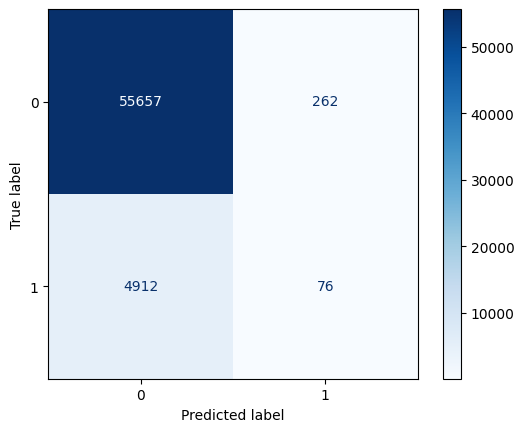

In [13]:
# Predict on the validation set
y_val_pred = model.predict(X_val_scaled).round().astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
# Print classification report
print(classification_report(y_val, y_val_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC-AUC Score: {roc_auc}')

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55919
           1       0.22      0.02      0.03      4988

    accuracy                           0.92     60907
   macro avg       0.57      0.51      0.49     60907
weighted avg       0.86      0.92      0.88     60907

ROC-AUC Score: 0.5052756096560965


In [15]:
# Predict on the test set
df_test_original['TARGET'] = model.predict(X_test_scaled).round().astype(int)

# Export the predictions to a CSV file
df_test_original.to_csv('df_test_original_predictions_deep_learning.csv', index=False)

1493/1493 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
